###### Question :
I decided to treat this as a classification problem by creating a new binary variable affair (did the woman have at least one affair?) and trying to predict the classification for each woman.

##### Dataset
The dataset I chose is the affairs dataset that comes with Statsmodels. It was derived from a survey of women in 1974 by Redbook magazine, in which married women were asked about their participation in extramarital affairs. More information about the study is available in a 1978 paper from the Journal of Political Economy.

Description of Variables The dataset contains 6366 observations of 9 variables:

rate_marriage: woman's rating of her marriage (1 = very poor, 5 = very good)            
age: woman's age                                                            
yrs_married: number of years married                                     
children: number of children                                                  
religious: woman's rating of how religious she is (1 = not religious, 4 = strongly religious)                            
educ: level of education (9 = grade school, 12 = high school, 14 = some college, 16 = college graduate, 17 = some graduate school, 20 = advanced degree)                                            
occupation: woman's occupation (1 = student, 2 = farming/semiskilled/unskilled, 3 = "white collar", 4 = teacher/nurse/writer/technician/skilled, 5 = managerial/business, 6 = professional with advanced degree)                   
occupation_husb: husband's occupation (same coding as above)                                          
affairs: time spent in extra-marital affairs                                            

In [1]:
#importing necessary libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score
import seaborn as sns 
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scikitplot

In [2]:
data=sm.datasets.fair.load_pandas().data
data.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666


In [3]:
sm.datasets.fair.load_pandas().names

['rate_marriage',
 'age',
 'yrs_married',
 'children',
 'religious',
 'educ',
 'occupation',
 'occupation_husb',
 'affairs']

In [4]:
data.shape

(6366, 9)

In [5]:
data.isnull().sum()

rate_marriage      0
age                0
yrs_married        0
children           0
religious          0
educ               0
occupation         0
occupation_husb    0
affairs            0
dtype: int64

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6366 entries, 0 to 6365
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rate_marriage    6366 non-null   float64
 1   age              6366 non-null   float64
 2   yrs_married      6366 non-null   float64
 3   children         6366 non-null   float64
 4   religious        6366 non-null   float64
 5   educ             6366 non-null   float64
 6   occupation       6366 non-null   float64
 7   occupation_husb  6366 non-null   float64
 8   affairs          6366 non-null   float64
dtypes: float64(9)
memory usage: 447.7 KB


In [7]:
data.describe()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
count,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000
mean,4.109645,29.082862,9.009425,1.396874,2.426170,14.209865,3.424128,3.850141,0.705374
std,0.961430,6.847882,7.280120,1.433471,0.878369,2.178003,0.942399,1.346435,2.203374
min,1.000000,17.500000,0.500000,0.000000,1.000000,9.000000,1.000000,1.000000,0.000000
25%,4.000000,22.000000,2.500000,0.000000,2.000000,12.000000,3.000000,3.000000,0.000000
50%,4.000000,27.000000,6.000000,1.000000,2.000000,14.000000,3.000000,4.000000,0.000000
75%,5.000000,32.000000,16.500000,2.000000,3.000000,16.000000,4.000000,5.000000,0.484848
max,5.000000,42.000000,23.000000,5.500000,4.000000,20.000000,6.000000,6.000000,57.599991


In [8]:
(data["affairs"]>0).sum()

2053

In [9]:
(data["affairs"]<=0).sum()

4313

In [10]:
#add "affair" column: 1 represents having affairs, 0 represents not 
data["affairs"]=(data.affairs >0).astype(int)

In [11]:
data.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,1
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,1
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,1
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,1


In [12]:
data["affairs"].value_counts()

0    4313
1    2053
Name: affairs, dtype: int64

In [13]:
y, X = dmatrices('affairs ~ rate_marriage + age + yrs_married + children + \
religious + educ + C(occupation) + C(occupation_husb)', data, return_type="dataframe")

X = X.rename(columns = {'C(occupation)[T.2.0]':'occ_2', 
                        'C(occupation)[T.3.0]':'occ_3', 
                        'C(occupation)[T.4.0]':'occ_4', 
                        'C(occupation)[T.5.0]':'occ_5', 
                        'C(occupation)[T.6.0]':'occ_6', 
                        'C(occupation_husb)[T.2.0]':'occ_husb_2', 
                        'C(occupation_husb)[T.3.0]':'occ_husb_3', 
                        'C(occupation_husb)[T.4.0]':'occ_husb_4', 
                        'C(occupation_husb)[T.5.0]':'occ_husb_5', 
                        'C(occupation_husb)[T.6.0]':'occ_husb_6'})

y = np.ravel(y)

In [14]:
X

,Intercept,occ_2,occ_3,occ_4,occ_5,occ_6,occ_husb_2,occ_husb_3,occ_husb_4,occ_husb_5,occ_husb_6,rate_marriage,age,yrs_married,children,religious,educ
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,32.0,9.0,3.0,3.0,17.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,27.0,13.0,3.0,1.0,14.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,22.0,2.5,0.0,1.0,16.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,37.0,16.5,4.0,3.0,16.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,27.0,9.0,1.0,1.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6361,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,32.0,13.0,2.0,3.0,17.0
6362,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,32.0,13.0,1.0,1.0,16.0
6363,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,22.0,2.5,0.0,2.0,14.0
6364,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,32.0,6.0,1.0,3.0,14.0


In [15]:
# Checking for null Values
X.isnull().sum()

Intercept        0
occ_2            0
occ_3            0
occ_4            0
occ_5            0
occ_6            0
occ_husb_2       0
occ_husb_3       0
occ_husb_4       0
occ_husb_5       0
occ_husb_6       0
rate_marriage    0
age              0
yrs_married      0
children         0
religious        0
educ             0
dtype: int64

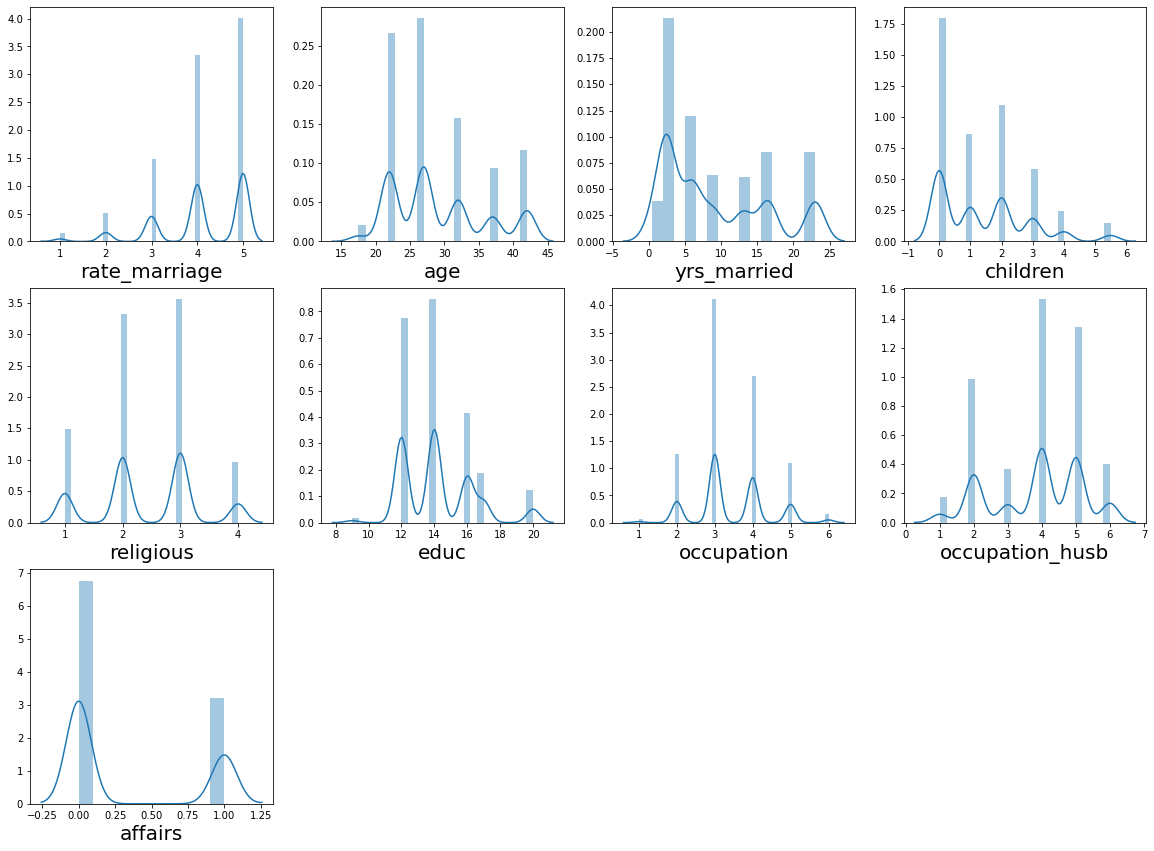

In [16]:
plt.figure(figsize=(20,25))
plotnumber = 1

for col in data:
    if plotnumber<=17 :
        ax = plt.subplot(5, 4, plotnumber)
        sns.distplot(data[col])
        plt.xlabel(col,fontsize=20)
    plotnumber+=1
plt.show()

Most of the data is categorical in nature. While the numerical data seems within a considerable range.                  
Therefore we won't go for Scaling the data                                    

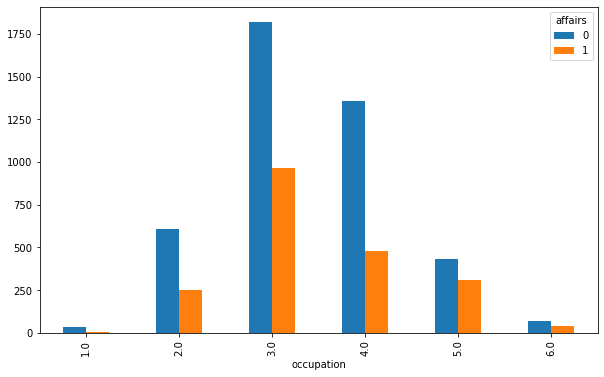

In [17]:
pd.crosstab(data.occupation, data.affairs).plot(kind='bar', figsize=[10,6])
plt.show()

<AxesSubplot:xlabel='occupation_husb'>

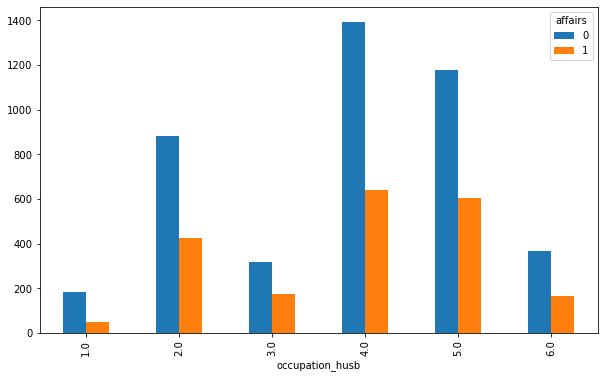

In [18]:
pd.crosstab(data.occupation_husb, data.affairs).plot(kind='bar', figsize=[10,6])

<AxesSubplot:xlabel='children'>

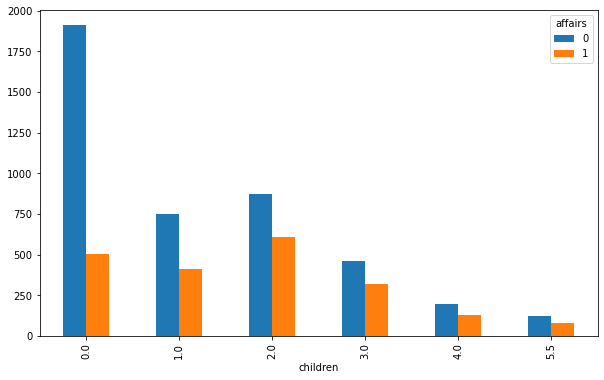

In [19]:
pd.crosstab(data.children,data.affairs).plot(kind="bar",figsize=[10,6])

In [20]:
y.mean()

0.3224945020420987

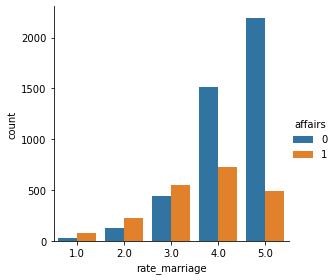

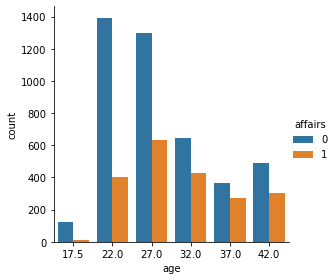

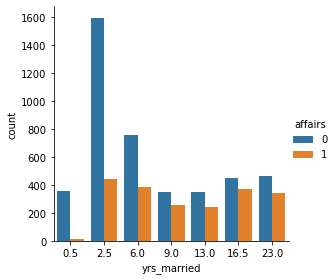

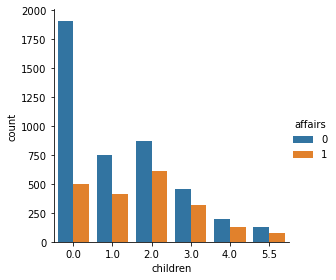

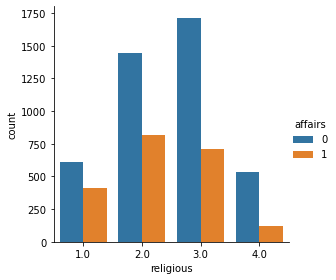

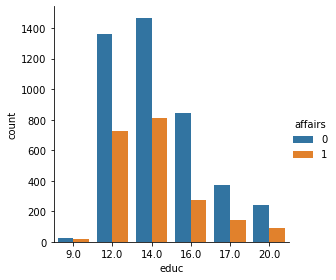

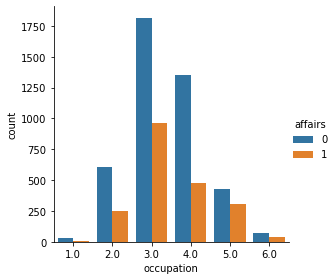

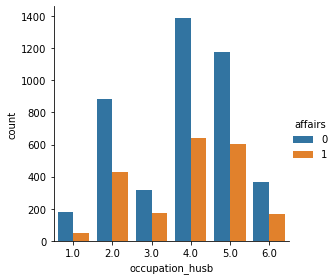

In [21]:
for col in data.columns:
    if col != "affairs":
        sns.catplot(x=col, hue="affairs" , kind="count", data=data, orient="v", height=4)
        plt.show()

In [22]:
X_arr = X.to_numpy()

### VIF

In [23]:
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X_arr,i) for i in range(X.shape[1])]
vif["Features"] = X.columns
vif

,VIF,Features
0,298.668600,Intercept
1,19.340780,occ_2
2,39.335618,occ_3
3,32.931910,occ_4
4,17.057165,occ_5
5,3.697959,occ_6
6,5.566292,occ_husb_2
7,2.991070,occ_husb_3
8,6.930281,occ_husb_4
9,6.577077,occ_husb_5


<AxesSubplot:>

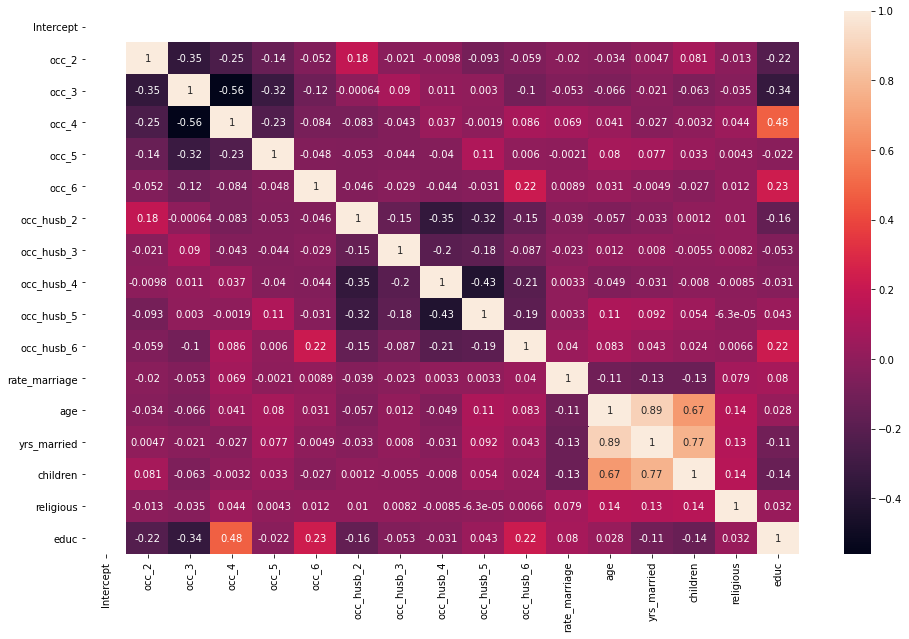

In [24]:
# Correlation
plt.figure(figsize=[16,10])
sns.heatmap(X.corr(), annot=True)

In [25]:
#Dropping 'Intercept' Column as it only has single value¶
X.drop("Intercept",axis=1, inplace=True)

In [26]:
X.columns

Index(['occ_2', 'occ_3', 'occ_4', 'occ_5', 'occ_6', 'occ_husb_2', 'occ_husb_3',
       'occ_husb_4', 'occ_husb_5', 'occ_husb_6', 'rate_marriage', 'age',
       'yrs_married', 'children', 'religious', 'educ'],
      dtype='object')

In [27]:
#spliting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=321)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4774, 16)
(1592, 16)
(4774,)
(1592,)


In [28]:
log_reg=LogisticRegression()
log_reg.fit(X_train,y_train)

C:\Users\monik\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [29]:
# Predicting for Test Set
y_pred=log_reg.predict(X_test)

In [30]:
# Accuracy Score
accuracy=accuracy_score(y_test,y_pred)
accuracy

0.7292713567839196

In [31]:
# Confusion Matrix
conf_mat =confusion_matrix(y_test,y_pred)
conf_mat

array([[979, 102],
       [329, 182]], dtype=int64)

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

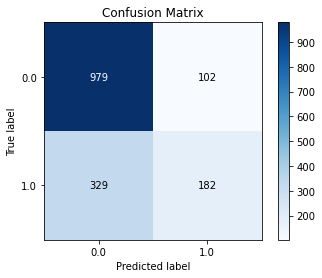

In [32]:
scikitplot.metrics.plot_confusion_matrix(y_test, y_pred)

In [33]:
true_positive=conf_mat[0][0]
false_positive=conf_mat[0][1]
false_negative=conf_mat[1][0]
true_negative=conf_mat[1][1]

In [34]:
# Breaking down the formula for Accuracy
Accuracy = (true_positive + true_negative) / (true_positive +false_positive + false_negative + true_negative)
Accuracy

0.7292713567839196

In [35]:
# Precison
Precision = true_positive/(true_positive+false_positive)
Precision

0.9056429232192414

In [36]:
# Recall
Recall = true_positive/(true_positive+false_negative)
Recall

0.7484709480122325

In [37]:
# F1 Score
F1_Score = 2*(Recall * Precision) / (Recall + Precision)
F1_Score

0.8195897865215572

In [38]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.75      0.91      0.82      1081
         1.0       0.64      0.36      0.46       511

    accuracy                           0.73      1592
   macro avg       0.69      0.63      0.64      1592
weighted avg       0.71      0.73      0.70      1592



In [39]:
# Area Under Curve
auc = roc_auc_score(y_test, y_pred)
auc

0.6309036533904427

**ROC**

In [40]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

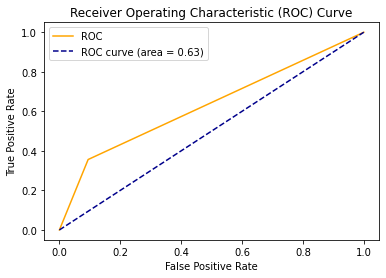

In [41]:
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='ROC curve (area = %0.2f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()